# Powertrain for UAV

In [548]:
%matplotlib inline
from scipy.integrate import quad, ode, odeint
from scipy import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import gym
np.random.seed(43)

### Battery profile

In [276]:
def get_poly(curve, pwr=5):
    """
        @brief: gets the coefficients for a polynomial approximation of given curve
        
        @input:
            curve: the curve as an np.array
            pwr: power of the curve to fit, default=5
        
        @output:
            an np.array of length(pwr) representing the coefficients of the curve
    """ 
    x_poly = np.arange(0, len(curve))
    y_poly = np.polyfit(x_poly, curve, pwr)
    return y_poly

def get_battery_curves(soc_ocv_file, R0_degradation_file, Q_degradation_file):
    """
        @brief: gets the degradation profile (predefined curves) for the battery
        
        @input:
            soc_ocv_file: a csv file containing the soc_ocv relationship as a column vector
            R0_degradation_file: a csv file containing the R0 degradation curve as a column vector
            Q_degradation_file: a csv file containing the Q degradation curve as a column vector
        
        @output:
            a dictionary mapping of degradation curve coefficients with ["z_coef", "r0_coef", "q_coef", "EOL"] keys
    """    
    soc_ocv = []
    R0_degradation = []
    Q_degradation = []
    
    with open(soc_ocv_file, newline='') as f:
        soc_ocv = list(csv.reader(f))
    soc_ocv = np.asarray(soc_ocv).astype(np.float)
    
    with open(R0_degradation_file, newline='') as f:
        R0_degradation = list(csv.reader(f))
    R0_degradation = np.asarray(R0_degradation).astype(np.float)
    
    with open(Q_degradation_file, newline='') as f:
        Q_degradation = list(csv.reader(f))
    Q_degradation = np.asarray(Q_degradation).astype(np.float)
    
    z_coef = get_poly(soc_ocv)
    r0_coef = get_poly(R0_degradation)
    q_coef = get_poly(Q_degradation)
    eol = len(Q_degradation)
    
    return {"z_coef": z_coef, "r0_coef": r0_coef, "q_coef": q_coef, "eol": eol, "soc_ocv": soc_ocv}



### Base Battery Cell

In [531]:
class Battery:
    def __init__(self, *args, **kwargs):
        if(len(kwargs) == 0):
            self.z_coef = np.zeros((1,1))
            self.r0_coef = np.zeros((1,1))
            self.q_coef = np.zeros((1,1))
            self.eod = 1
            self.eol = 1
        else:
            self.z_coef = kwargs["z_coef"]
            self.r0_coef = kwargs["r0_coef"]
            self.q_coef = kwargs["q_coef"]
            self.eol = kwargs["eol"]
        self.z = 1.0
        self.Ir = 0
        self.h = 0
        self.M0 = .0019
        self.M = .0092
        self.R0 = .0112
        self.R = 2.83e-4
        self.Q = 3.8695
        self.n = .9987
        self.G = 163.4413
        self.v0 = 4.2
        self.eod = 3.04
        self.RC = 3.6572
        self.ocv = self.v0
        
    def get_ocv(self):
        raise NotImplementedError
    
    def step(self, dt, current):
        raise NotImplementedError
        
    def reset(self):
        self.z = 1.0
        self.ocv = self.v0
        self.Ir = 0
        self.h = 0
        

### The Continuous Battery Cell

In [656]:
class ContinuousBatteryCell(Battery, gym.Env):
    def __init__(self, *args, **kwargs):
        super(ContinuousBatteryCell, self).__init__(*args, **kwargs)

        # simple moving average filter
        self.filter_len = 25
        self.filter = lambda X: np.sum(X)/self.filter_len
        
        # accumulator and index for moving average filter
        self.accum = np.zeros((self.filter_len,))
        self.idx = 0
        
        # obs[0] = noisy observation of soc, obs[1] = filtered observation of soc
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(2,))
        self.state = [100.0, 100.0]
        
        # 0 for charging, 1 for discharging, not implemented yet
        self.action_space = gym.spaces.Discrete(2) # charging or discharging
        
        # used for ode solver
        self.nsteps = lambda x: np.linspace(0, x, 100)

        # random seed to aid reproduction
        self._seed = 43
        self.seed(self._seed)
        
    def seed(self, seed):
        """sets the random seed"""
        self.observation_space.seed(self._seed)
        self.action_space.seed(self._seed)
        
    def get_v(self, z):
        """returns the ideal open circuit voltage for a given state of charge"""
        assert z >= 0.0 and z <= 100.0, "z in range [0.0, 100.0]"
        return np.polyval(self.z_coef, z)[0]

    def get_r0(self, age):
        """returns the value of r0 at a given battery age"""
        assert age >= 0.0 and age <= self.eol, "age in range [0.0, {}]".format(self.eol)
        return np.polyval(self.r0_coef, age)[0]
    
    def get_q(self, age):
        """returns the charge capacity at a given battery age"""
        assert age >= 0.0 and age <= self.eol, "age in range [0.0, {}]".format(self.eol)
        return np.polyval(self.q_coef, age)[0]
    
    def _dzdt(soc, t, current):
        """first order de for state of charge"""
        return -self.n*current/self.Q

    def _didt(Ir, t, current):
        """first order de for the """
        return -1.0/self.RC*Ir + 1.0/self.RC*current

    def _dhdt(h, t, current):
        return -np.absolute(self.n*current*self.G/self.Q)*h + self.n*current*self.G/self.Q*self.M*np.sign(current)
    
    def step(self, dt, current):
        _z = (1 - odeint(dzdt, 1.0, dt, args=(c,))[-1][0])
        _i = odeint(didt, self.Ir, dt, args=(c,))[-1][0]
        _h = odeint(dhdt, self.h, dt, args=(c,))[-1][0]
        self.Ir = _i
        self.z = self.z - _z   
        self.h = _h
        self.ocv = np.polyval(self.z_coef, self.z*100.0) - self.R*self.Ir - self.R0*current + self.h + self.M0*np.sign(current)
        noisy = np.clip(np.random.normal(self.z, .01), 0.0, 100.0)
        if(self.accum[-1] == 0):
            self.accum = np.ones((self.filter_len,))*noisy
        else:
            self.accum[self.idx] = noisy
        self.idx += 1
        if(self.idx == self.filter_len):
            self.idx = 0
        filtered = np.clip(self.filter(self.accum), 0.0, 100.0)
        self.state = [noisy, filtered]
            
        reward = -.01
        done = True if self.ocv <= self.eod+.1 else False
        #print(self.accum)
        return self.state, reward, done, locals()
        
        
    def reset(self):
        super().reset()
        self.state = self.z
        self.observed = np.random.normal(self.state, .01)

### create the battery cell

In [657]:
battery_coefficients = get_battery_curves('soc_ocv.csv', 'R0_degradation.csv', 'Q_degradation.csv')
cbcell = ContinuousBatteryCell(**battery_coefficients)

### Simulate continuous cell under varying load until eod

In [655]:
cbcell.reset()
cs = []
cz = []
cn = []
cf = []
cv = []
ct = 1/3600/20 # 1/20th of a second, i.e. .05 seconds
t1 = cbcell.nsteps(ct)
x = np.linspace(0, 2*np.pi, int(cbcell.z*100)+1)
y = np.sin(2*-x**1.1)/4+8
i = 0

done = False
while(not done):#ocv > cbcell.eod):
    #c = 3.8695
    c = np.random.normal(y[int(cbcell.z*100)], .1)
    obs, reward, done, info = cbcell.step(t1, c)
    cs.append(c)
    cz.append(cbcell.z)
    cn.append(obs[0])
    cf.append(obs[1])
    #print(obs)
    cv.append(cbcell.ocv)
    i += 1
    
t = int(i*.05)
print("elapsed seconds: {:.2f}".format(t))
print("ending soc: {:.4f}".format(cbcell.z))

elapsed seconds: 1703.00
ending soc: 0.0276


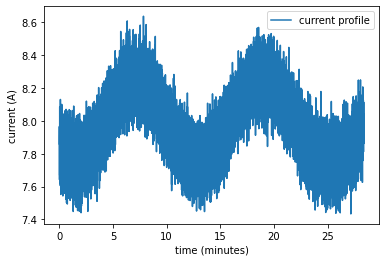

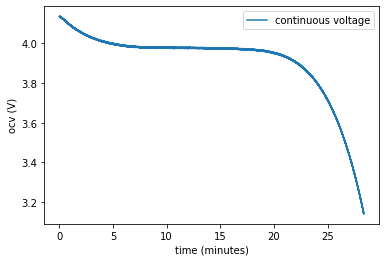

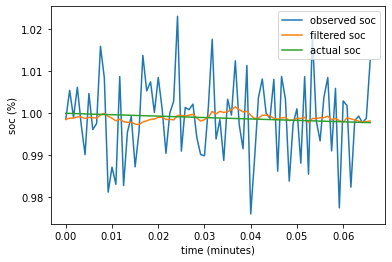

In [653]:
plt.plot(np.arange(0, i)/60/20, cs, label='current profile')
plt.ylabel('current (A)')
plt.xlabel('time (minutes)')
plt.legend()
plt.show()

plt.plot(np.arange(0, i)/60/20, cv, label='continuous voltage')
plt.ylabel('ocv (V)')
plt.xlabel('time (minutes)')
plt.legend()
plt.show()  

plt.plot(np.arange(0, i)[0:80]/60/20, cn[0:80], label='observed soc')
plt.plot(np.arange(0, i)[0:80]/60/20, cf[0:80], label='filtered soc')
plt.plot(np.arange(0, i)[0:80]/60/20, cz[0:80], label='actual soc')
plt.ylabel('soc (%)')
plt.xlabel('time (minutes)')
plt.legend()
plt.show()  

### plot the battery profile curves
- q degradation
- r0 degradation
- soc ocv curve

4.052408561253653
0.0037714030047914585
2.6391768798904733


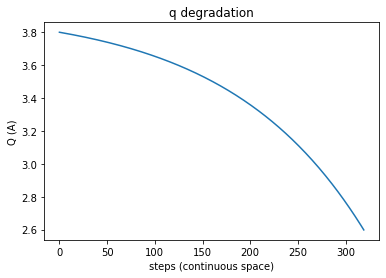

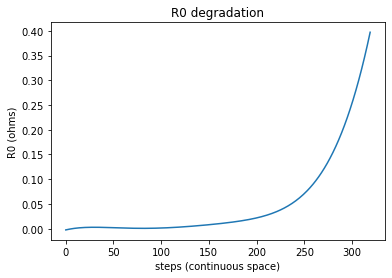

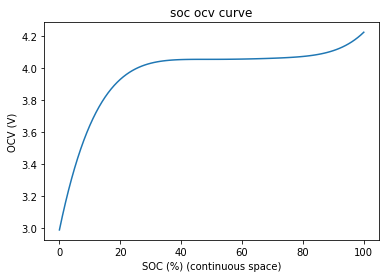

In [658]:
# shows that profile curves are continuous
print(cbcell.get_v(z=45.32434))
print(cbcell.get_r0(age=123.232))
print(cbcell.get_q(age=314.54243534))

plt.plot(np.arange(0, cbcell.eol), np.polyval(cbcell.q_coef, np.arange(0, cbcell.eol)))
plt.title('q degradation')
plt.ylabel('Q (A)')
plt.xlabel('steps (continuous space)')
plt.show()
plt.plot(np.arange(0, cbcell.eol), np.polyval(cbcell.r0_coef, np.arange(0, cbcell.eol)))
plt.title('R0 degradation')
plt.ylabel('R0 (ohms)')
plt.xlabel('steps (continuous space)')
plt.show()
plt.plot(np.arange(0, 101), np.polyval(cbcell.z_coef, np.arange(0, 101)))
plt.title('soc ocv curve')
plt.ylabel('OCV (V)')
plt.xlabel('SOC (%) (continuous space)')
plt.show()

### The Discrete Battery Cell

In [359]:
class DiscreteBatteryCell(Battery):
    def __init__(self, *args, **kwargs):
        super(DiscreteBatteryCell, self).__init__(*args, **kwargs)
        self.soc_ocv = kwargs['soc_ocv']
        
    def get_ocv(self):
        if(self.z < 0.0):
            self.z = 0
        elif(self.z > 1.0):
            self.z = 1.0
        idx = int(np.ceil(self.z*100))
        if(idx > 101):
            idx = 101
        elif(idx < 1):
            idx = 1
        return self.soc_ocv[idx]
        
    def step(self, dt, current):
        RC = np.exp(-dt/abs(self.RC))
        H = np.exp(-abs(self.n*current*self.G*dt/(3600*self.Q)))
        self.Ir = RC*self.Ir + (1-RC)*current
        self.h = H*self.h + (H-1)*np.sign(current)
        self.z = self.z - self.n*current/3600/self.Q
        self.ocv = self.get_ocv() + self.M*self.h + self.M0*np.sign(current) - self.R*self.Ir - self.R0*current
        

In [441]:
dbcell = DiscreteBatteryCell(**battery_coefficients)

### Simulate and compare cells
- dt = 1 second, current = 3.8695
- the cell capacity is 3.8695 mAh, so, i should be ~3600 
- the cell asymptotically approaches the eod, so have to stop slightly above

simulating 3.8695 amp draw for 1 hr (3600 seconds)...
discrete soc: 0.0019
discrete seconds elapsed: 3598
continuous soc: 0.0019
continuous seconds elapsed: 3598


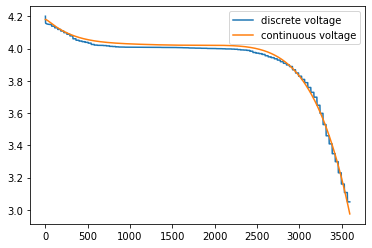

In [596]:
################# DEPRECIATED
# def continuous_test2():
#     """ simulate continuous cell for 1 hr"""
#     cbcell.reset()
#     dt = 1/3600 # 1 second
#     t1 = nsteps(dt)
#     ocvs = []
#     i = 0
#     while(cbcell.z > .002):
#         c = 3.8695
#         cbcell.step(t1, c)
#         ocvs.append(cbcell.get_ocv() - cbcell.R*cbcell.Ir - cbcell.R0*current + cbcell.h + cbcell.M0*np.sign(current))
#         dz = (1 - odeint(dzdt, 1.0, t1, args=(c,))[-1][0])
#         di = odeint(didt, cbcell.Ir, t1, args=(c,))[-1][0]
#         dh = odeint(dhdt, cbcell.h, t1, args=(c,))[-1][0]
#         cbcell.Ir = di
#         cbcell.z = cbcell.z - dz   
#         cbcell.h = dh
#         i += 1
#     print("continuous soc: {:.4f}".format(cbcell.z))
#     print("continuous seconds elapsed: " + str(i))
#     return ocvs

# def discrete_test2():
#     """simulate discrete cell for 1 hr"""
#     dbcell.reset()
#     dt = 1.0
#     ocvs = []
#     i = 0
#     while(dbcell.z > .002):
#         c = 3.8695
#         ocvs.append(dbcell.ocv)
#         dbcell.step(1, c)
#         i += 1
#     print("discrete soc: {:.4f}".format(dbcell.z))
#     print("discrete seconds elapsed: " + str(i))
#     return ocvs

# print("simulating 3.8695 amp draw for 1 hr (3600 seconds)...")

# docvs = discrete_test2()
# cocvs = continuous_test2()
# plt.plot(docvs, label='discrete voltage')
# plt.plot(cocvs, label='continuous voltage')
# plt.legend()
# plt.show()